# Biophysics Assignment 4: Information Theory and Luria Delbruck Simulations

## William Cerny
## Due Date: 5/21/20

In [1]:
import numpy as np, matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import collections
%matplotlib inline

# Part 1: Entropy and Information of Language

## Question 1:

### Load in text of the first bit of Harry Potter

In [2]:
text = open("HarryPotter_sample.txt", "r") 
readable = str(text.read()).lower()

### Find Frequencies of each letter

In [3]:
results = dict(collections.Counter(readable)) ## python magic does it all for me...

In [4]:
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
frequencies = []
for letter in alphabet: 
    frequencies.append(results[letter])
    
frequencies = np.array(frequencies)
n = np.sum(frequencies) ## total number of letters 

### View Distribution:

Text(0.5, 1.0, 'Distribution of Letters, n = 79505')

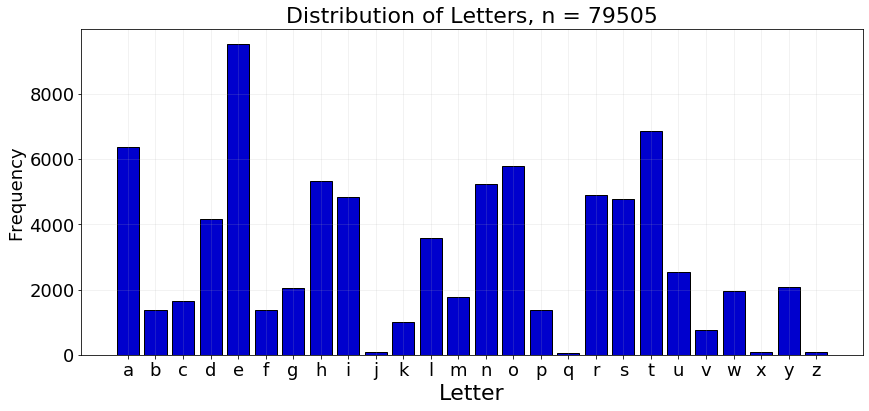

In [5]:
plt.figure(figsize = (14,6))
plt.bar(alphabet, frequencies, color = 'mediumblue', edgecolor = 'black')
plt.grid(alpha = .2)
_ = plt.xlabel('Letter', fontsize = 22)
_ = plt.xticks(fontsize = 18)
_ =  plt.yticks(fontsize = 18)
plt.ylabel('Frequency', fontsize = 18)
plt.title('Distribution of Letters, n = %d'%n, fontsize = 22)

## Question 2: Calculate Entropy 

Entropy can be calculated as $$ S = -1 * \sum_{i}^{}  p_i * log(p_i)$$ 

### First, find probabilities of each letter in Harry Potter:

In [6]:
probabilities = frequencies/n
print('The sum of all probabilities is:',np.sum(probabilities))

The sum of all probabilities is: 1.0


In [7]:
Entropy = -1 * np.sum([p * np.log2(p) for p in probabilities]) ## log base 2 to get S in bits

In [8]:
print('Resulting Entropy from Harry Potter is: ',Entropy)

Resulting Entropy from Harry Potter is:  4.203661305487588


### Whereas entropy in the uniform case is:

$$ S_{uniform} = -1 * \sum_{i=1}^{26}  \frac{1}{26} * \log(\frac{1}{26}) = \frac{26}{26}* \log(26) = \log(26)$$

Which is also found computationally assuming base 2 log as...

In [24]:
p_uniform = (np.zeros(26))
p_uniform[:]= (1/26)
Entropy_uniform = -1 * np.sum([p * np.log2(p) for p in p_uniform]) 
print('Resulting Entropy from Uniform distribution  is: ',Entropy_uniform)

Resulting Entropy from Uniform distribution  is:  4.700439718141092


### The unit of each of these entropies is bits per letter.


### For the uniform case, Shannon's formula evaluates to the maximum entropy possible. Thus, the entropy of the Harry Potter non-uniform case must be lower, which is what I found to be true. The difference between the two is ~.5 bits per letter, suggesting that there is less information per letter in the case of the "true English" distribution of letters.

# Question 3

### Thus, across a text of length 79505 characters, the space saved is:

In [25]:
n * (Entropy_uniform - Entropy)

39496.36769801678

### This means that you would need nearly 40,000 more bits to express the text I analyzed above if one used a system where the number of bits for each unique character is uniform than it would to use a system that scales the number of bits for each letter to be dependent on frequency.

# ------------------------------------------------------------------------------------------------------------

# Part 2: Luria Delbruck Simulations

## Notes on the Setup and Conventions

## I will be using the conventions established in lecture. This has multiple key features that are vital to understanding the simulation results:

### 1) The initial generation is called g=0. The final, 10th generation, is therefore called g=9.

### 2) Age is defined as the number of generations counting backwards from g=9 to the point when the bacteria initially mutates. This means, very importantly, that the minimum age is set to be 1.

### 3) No mutations happen at generation g=0. Thus, the maximum observed clone age is 9, rather than 10.

### 4) Replications happen before mutation. 

### The net result of these combined means that if a mutant originates at the second generation, aka g= 1,  for example, then it will have a final age G-1, and thus 2^(G-2) offspring in the final generation.  Age and clone size are related by 

$$ \text{Clone Size} = \frac{2^{Clone Age}}{2} = 2^{Clone Age -1}$$

### (as derived in lecture).








The above can be justified with a thought experiment. Consider the case when a single non-mutant exists at generation g=0. We want to find the resulting age and clone size distributions at g=2.

At g=0, nothing happens. The initial bacteria just replicates.
At g=1, there are two bacteria due to the prior replication. Since replication just occurred, a mutation event can now happen. Let's say that one of these bacteria mutate. The two bacteria, each of different types, then replicate.
At g=3, there are now 4 bacteria, 2 of which are mutant, and 2 of which are nonmutant. A mutation event occurs, but nothing mutates. 

The resulting statistics to be reported would be:

Number of mutants in final population: 2 
Clone ages: there would be a single observation that is exactly age 2. This is because the initial mutation occured in generation g=1, so the age is G-g = 3-1 = 2. 
Clone sizes: Using the formula above, we have $2^{2}$ / 2 = 2. This matches our expectation of 2 mutants in the final population.

## Notes on the Computational Strategy

### The key conceptual technique used in this simulation is the fact that both clone age and clone dependent size in the final generation are uniquely determined by the generation in which a mutant flips from 'a' to 'A'. This is because of three key features of the setup: 1) mutants cannot revert to 'a' 2) all bacteria always reproduce once per generation, and 3) mutation rate does not discriminate based on population size. This means that the only information needed to be stored is the age at which a bacteria initially mutates. This is how I proceed.




## Notes on the Programming

For efficiency, I store 'a' as 0, 'A' as 1 for memory efficiency and speed. I had initially started out with a fun (in my view) recursive object oriented approach with self-duplicating objects, but scrapped that because to get statistically robust histograms, it was convenient to run thousands of simulations and that method became too slow. So, I decided to go the alternate route which is this minimalistic approach which is very speedy.

The key Python trick here is use vectorized numpy arrays and the np.repeat method, which duplicates the entire array extremely quicky, ie, it turns [0,1,0,0] into [0,0,1,1,0,0,0,0]. The one lingering inefficiency here is the fact that I generate population_size random numbers every time, rather than one per non-mutant; while I only perform the comparison with alpha for the non-mutants, this method is just simpler programatically and is not too much slower given that np.random.uniform can generate npop random numbers nearly instantaneously with basically no cost to speed.


(Extra note: Professor Murugan specifically told us after class one day that switching from 20->10 generations was fine, as it helps allow for more iterations of the simulation and thus better robustness in this distributions).

Starting with 2 in the population initially is a conscious choice. He said to start with arbitrary "n" but that grows very very quickly for n>1, so I chose 2 because it demonstrates that this works for n>1 but does not result in huge memory draw.

In [11]:
def runSimulation(n,alpha,numGenerations):

    population = np.zeros(n) ## all start as type 'a' => 0 
    flipAges = []
    
    for g in range(1,numGenerations): ### remaining 19 generations 

        population = np.repeat(population,2) ### duplicate

        rand_nums = (np.random.uniform(0, 1, len(population))) ### generate random sequence of length n
        
        
        for i,num in enumerate(rand_nums):
            if (num <= alpha) & (population[i] == 0): # mutate if random number is less than alpha
                population[i] = 1
                flipAges.append(numGenerations - g)  ## append age each time you mutate
        
    
    flipAges = np.array(flipAges)
    numMutants = len(np.where(population == 1)[0])  ## find number of mutants quickly
    
    del population ## free memory...
    return numMutants,flipAges

# Run 50,000 simulations for alpha = .1, n_initial = 2:

In [44]:
arr_numMutants = []
arr_flipAges = np.array([1])

for i in tqdm(range(50000)):
    a,b = runSimulation(n = 2,alpha = .1, numGenerations= 10)
    arr_numMutants.append(a)
    if i== 0: arr_flipAges = b
    else: arr_flipAges = np.concatenate([arr_flipAges, b]) ## grosly inefficient in terms of memory but sufficient


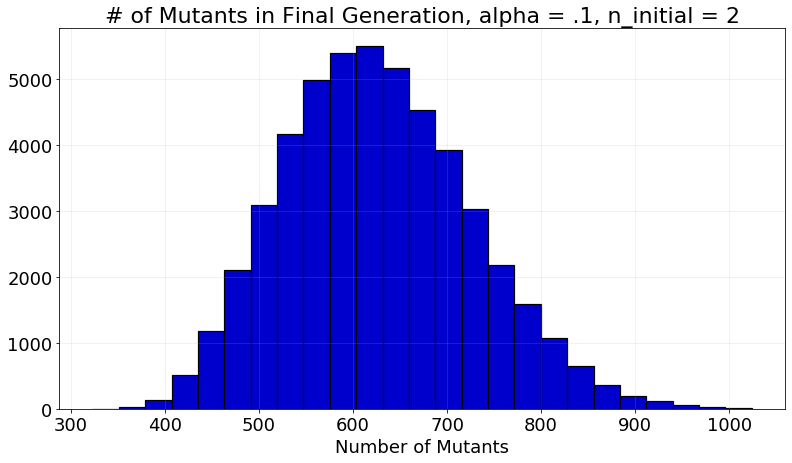

In [45]:
_ = plt.figure(figsize = (13,7))

plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
# plt.xlim(0,1024)
_ = plt.hist(arr_numMutants, bins = 25, edgecolor='black', linewidth=1.2, color = 'mediumblue')
plt.grid(alpha = .2)
_ = plt.title('# of Mutants in Final Generation, alpha = .1, n_initial = 2', fontsize = 22)
_ = plt.xlabel('Number of Mutants', fontsize = 18)

## The above looks as expected. A nice sanity check comes if one considers that the limiting case is exactly 1024 mutants, aka 2 * 2^9, on the x-axis, where the first 2 comes from the starting population (g=0) and the 2^9 comes from 9 generations of replication.

### The shape looks to be expected: certainly one would expect high variance, since very high variability is an intrinsic part of the Luria-Delbruck results since exponential growth "amplifies" the impact of the randomness in mutations. Since the probability of not have any mutations until late generations is very low, one does not seem many occurrences on the "left side" of the distribution, hence why the high-variance-inducing tail extends to the right primarily.

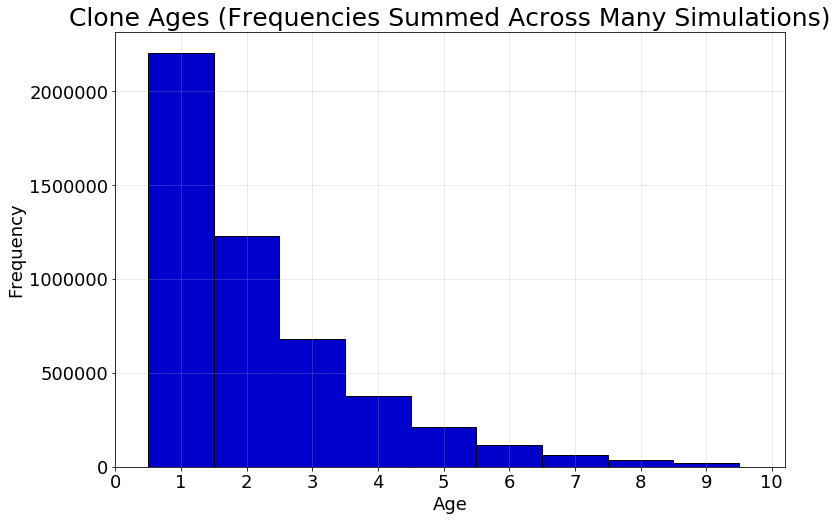

In [46]:
plt.figure(figsize = (12,8))

generations = np.arange(4) 
plt.hist(arr_flipAges, bins = np.arange(11)-.5, edgecolor = 'black', color = 'mediumblue')

plt.title('Clone Ages (Frequencies Summed Across Many Simulations)',fontsize = 25)
plt.xlim(1,10.2)

plt.xlabel('Age',fontsize = 18)
_ = plt.xticks(np.arange(11),fontsize = 18)
_ =  plt.yticks(fontsize = 18)
plt.ylabel('Frequency',fontsize = 18)
plt.grid(alpha = .3)

### (Recall there are exactly 0 at age 10 by construction, because generations indexed to begin at 0, with no mutations happening at first. Likewise, there are never any at 0, because age is defined to be 1 in the final generation by the Professor's scheme that I describe above).

## Lastly: note that in the following plot, clone size can be equal to 1. This might seem confusing, but this is because mutation happens after replication, so when a mutant flips in the last generation, it is recorded as part of the storing of ages with age = 1, and thus 
x
$$ \text{Clone Size} = \frac{2^{\text{Clone Age}}}{2} = \frac{2^{\text{1}}}{2} = 1$$

Text(0, 0.5, 'Frequency')

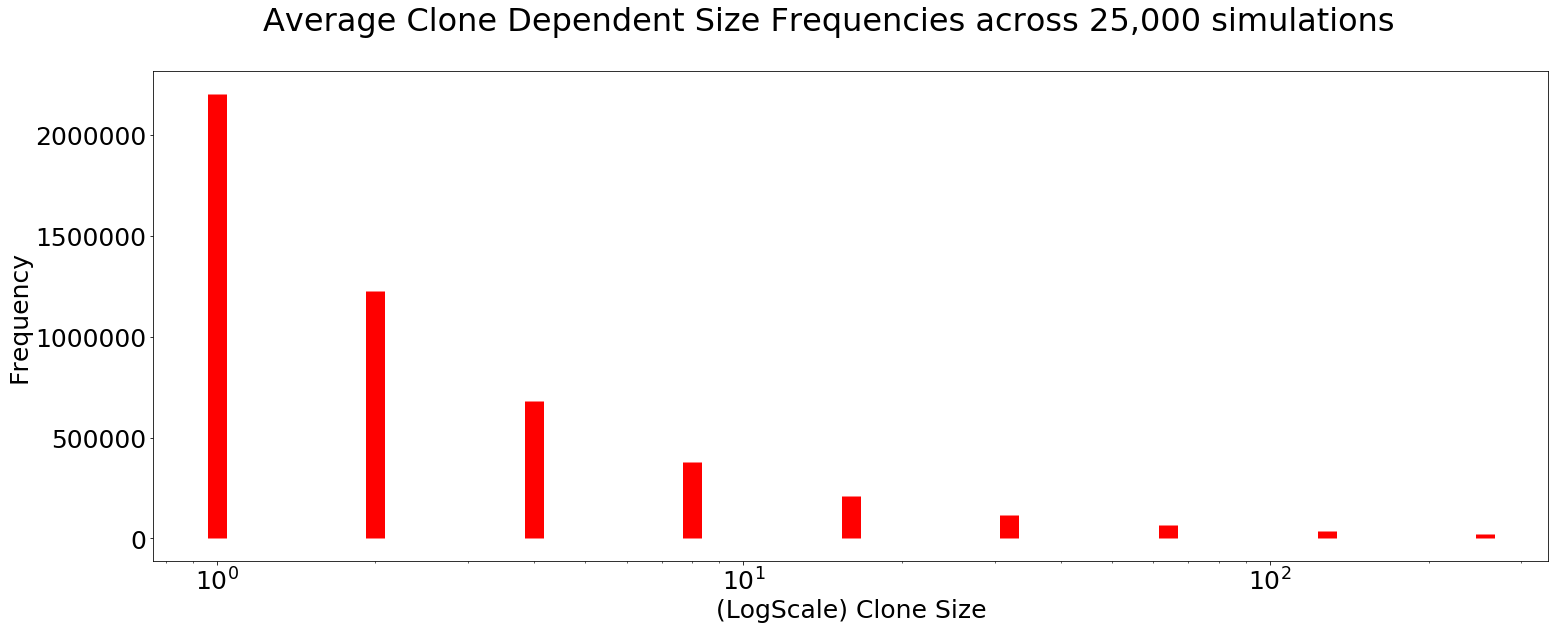

In [47]:
a,c = np.unique(2**(arr_flipAges-1), return_counts= True)
plt.figure(figsize = (25,9))
plt.suptitle('Average Clone Dependent Size Frequencies across 25,000 simulations',fontsize = 32)
plt.vlines(a,0,c, color = 'red', lw = 19)
plt.xscale('log')
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlabel('(LogScale) Clone Size', fontsize = 25)
plt.ylabel('Frequency', fontsize = 25)

### The above has to be plotted on logscale on the x-axis to look meaningful and uncluttered. The exact x-values of each bar are printed below:

In [48]:
a

array([  1,   2,   4,   8,  16,  32,  64, 128, 256])

# Now I use different values of alpha, starting with much smaller: alpha .01

In [49]:
arr_numMutants = []
arr_flipAges = np.array([1])

for i in tqdm(range(50000)):
    a,b = runSimulation(n = 2,alpha = .01, numGenerations= 10)
    arr_numMutants.append(a)
    if i== 0: arr_flipAges = b
    else: arr_flipAges = np.concatenate([arr_flipAges, b]) ## grosly inefficient in terms of memory but sufficient


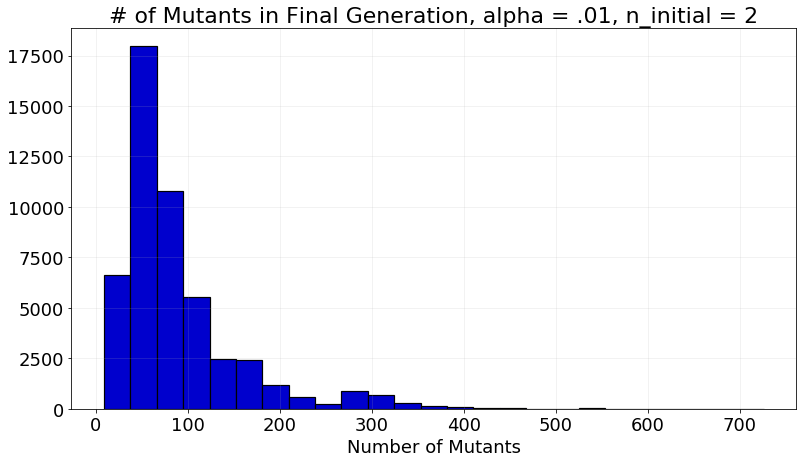

In [50]:
_ = plt.figure(figsize = (13,7))

plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
# plt.xlim(0,1024)
_ = plt.hist(arr_numMutants, bins = 25, edgecolor='black', linewidth=1.2, color = 'mediumblue')
plt.grid(alpha = .2)
_ = plt.title('# of Mutants in Final Generation, alpha = .01, n_initial = 2', fontsize = 22)
_ = plt.xlabel('Number of Mutants', fontsize = 18)

### Interpretation: The distribution clearly peaks at a lower number of mutants, as expected, since the number of mutants created early on is much lower, which has an amplified effect in later generations. However, you do still get a long right-tail to high values of end mutant population size, which must correspond to cases when early mutations do happen.

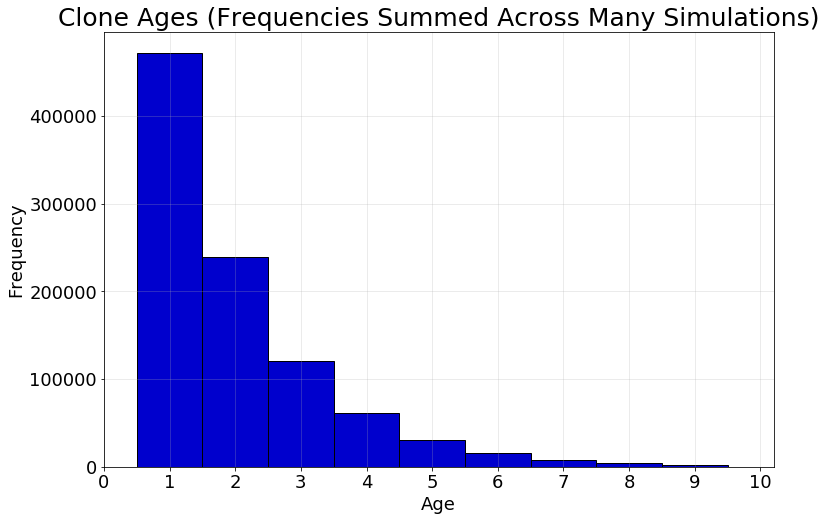

In [51]:
plt.figure(figsize = (12,8))

generations = np.arange(4) 
plt.hist(arr_flipAges, bins = np.arange(11)-.5, edgecolor = 'black', color = 'mediumblue')

plt.title('Clone Ages (Frequencies Summed Across Many Simulations)',fontsize = 25)
plt.xlim(1,10.2)

plt.xlabel('Age',fontsize = 18)
_ = plt.xticks(np.arange(11),fontsize = 18)
_ =  plt.yticks(fontsize = 18)
plt.ylabel('Frequency',fontsize = 18)
plt.grid(alpha = .3)

Text(0, 0.5, 'Frequency')

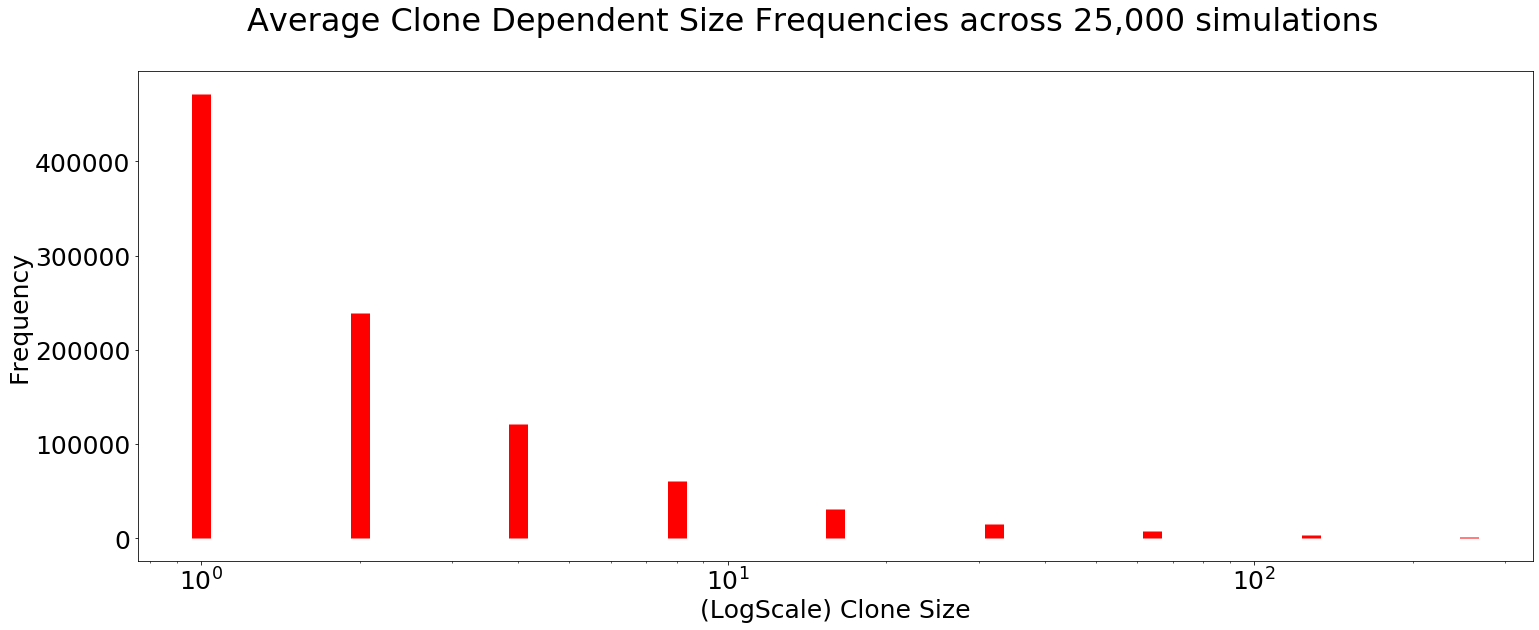

In [52]:
a,c = np.unique(2**(arr_flipAges-1), return_counts= True)
plt.figure(figsize = (25,9))
plt.suptitle('Average Clone Dependent Size Frequencies across 25,000 simulations',fontsize = 32)
plt.vlines(a,0,c, color = 'red', lw = 19)
plt.xscale('log')
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlabel('(LogScale) Clone Size', fontsize = 25)
plt.ylabel('Frequency', fontsize = 25)

### Interpretation: the above two plots are essentially identical to before, but with a significantly lower frequency, since it is much less common to have mutants. The overall pattern remains identical, however.

# Now for much larger alpha = .25:

In [53]:
arr_numMutants = []
arr_flipAges = np.array([1])

for i in tqdm(range(50000)):
    a,b = runSimulation(n = 2,alpha = .25, numGenerations= 10)
    arr_numMutants.append(a)
    if i== 0: arr_flipAges = b
    else: arr_flipAges = np.concatenate([arr_flipAges, b]) ## grosly inefficient in terms of memory but sufficient


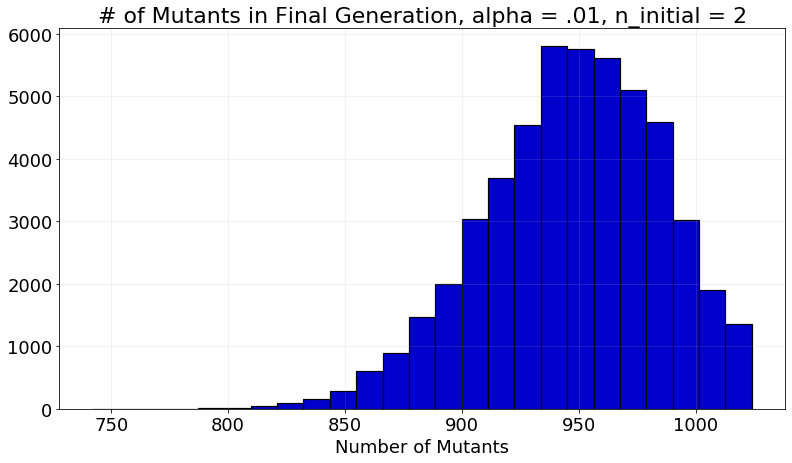

In [54]:
_ = plt.figure(figsize = (13,7))

plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
# plt.xlim(0,1024)
_ = plt.hist(arr_numMutants, bins = 25, edgecolor='black', linewidth=1.2, color = 'mediumblue')
plt.grid(alpha = .2)
_ = plt.title('# of Mutants in Final Generation, alpha = .01, n_initial = 2', fontsize = 22)
_ = plt.xlabel('Number of Mutants', fontsize = 18)

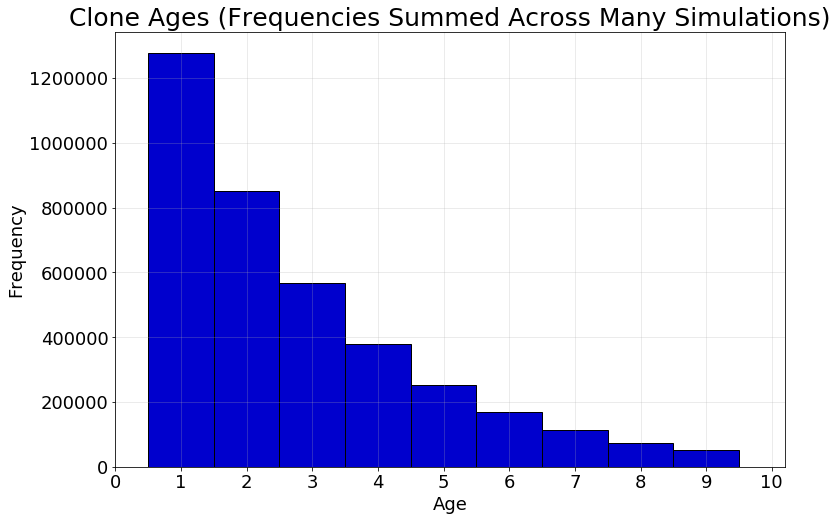

In [55]:
plt.figure(figsize = (12,8))

generations = np.arange(4) 
plt.hist(arr_flipAges, bins = np.arange(11)-.5, edgecolor = 'black', color = 'mediumblue')

plt.title('Clone Ages (Frequencies Summed Across Many Simulations)',fontsize = 25)
plt.xlim(1,10.2)

plt.xlabel('Age',fontsize = 18)
_ = plt.xticks(np.arange(11),fontsize = 18)
_ =  plt.yticks(fontsize = 18)
plt.ylabel('Frequency',fontsize = 18)
plt.grid(alpha = .3)

Text(0, 0.5, 'Frequency')

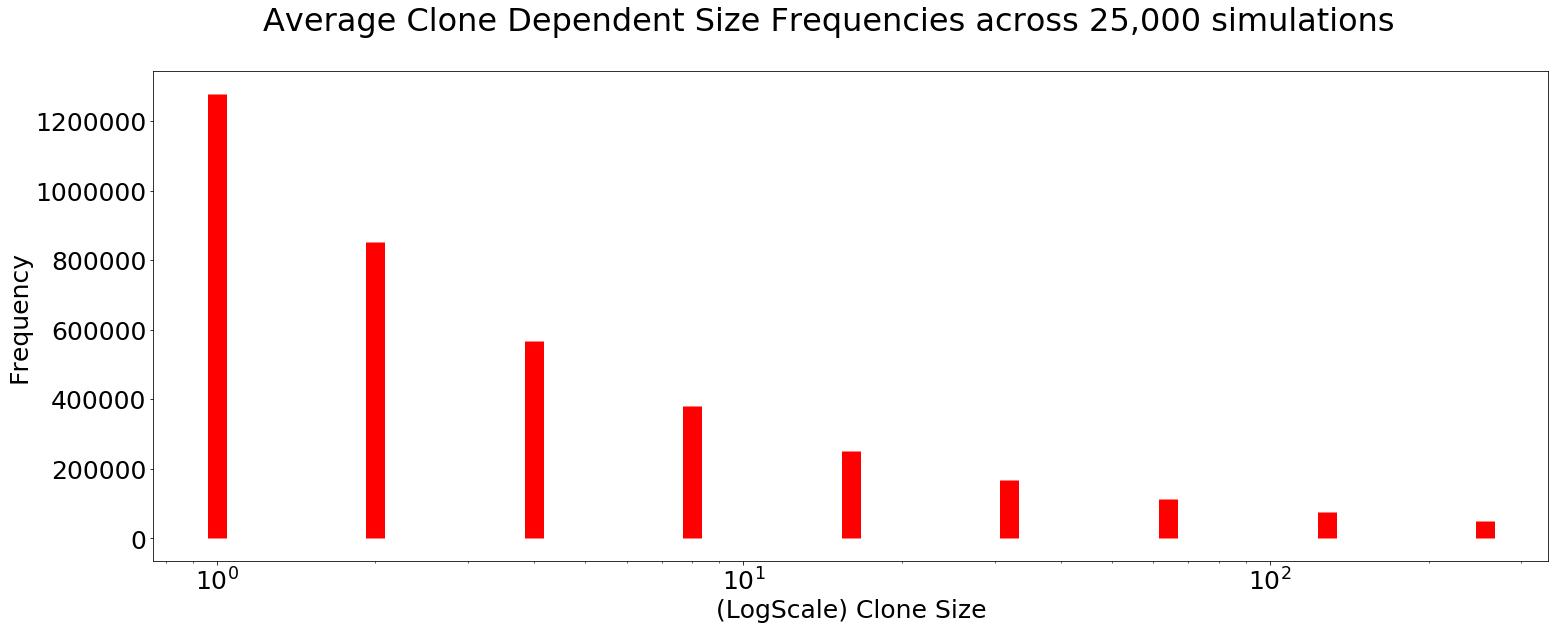

In [56]:
a,c = np.unique(2**(arr_flipAges-1), return_counts= True)
plt.figure(figsize = (25,9))
plt.suptitle('Average Clone Dependent Size Frequencies across 25,000 simulations',fontsize = 32)
plt.vlines(a,0,c, color = 'red', lw = 19)
plt.xscale('log')
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlabel('(LogScale) Clone Size', fontsize = 25)
plt.ylabel('Frequency', fontsize = 25)

### Interpretation: Here, the number of mutants is dramatically higher, and the resulting distribution begins to become the reverse of the initial case: it now has a long tail to the left (lower number of mutants) because the probability of having lower number of mutants becomes extremely unlikely due to the higher mutation rate. The next two plots are largely similar, except they have y-axes scales that include many more mutants than in the previous case.